# Сравнение топологии транспортной сети регионов РФ
на данных междугородных перемещений пассажирского транспорта, предоставленных Туту.ру

----------

Подготовил [Вадим Сафронов](https://www.linkedin.com/in/vadymsafronov/) для участников соревнований. 

Желающих закопаться в графы всегда рады видеть в каналах #network_analysis и #class_cs224w

---------

**Последовательность действий следующая:**
* берём все виды транспорта,
* строим направленный граф,
* считаем все возможные мотифы размерности в три вершины (т.к. в четыре - размер выхода считалки в 30 гигов получается и пока его ворочать не особо хочется),
* количество вхождений в мотифы - это наш стартовый вектор признаков вершин,
* его сворачиваем трижды (т.к. эффективный диаметр 90% графа у нас ~3),
* всё это пихаем в kmeans (для проверки гипотезы компактности),
* суммируем полученные вектора и получаем приближение теста изоморфизма Вейсфейлера-Лемана для регионов, либо усредняем и получаем масштабно-инвариантное отображение региона. 

In [ ]:
! pip install snap-stanford
! wget http://www.dcc.fc.up.pt/gtries/gtrieScanner_src_01.zip
! wget http://www.dcc.fc.up.pt/gtries/gtries.zip
! unzip gtrieScanner_src_01.zip
! unzip gtries.zip -d ./gtrieScanner_src_01
%cd gtrieScanner_src_01
! make 

import snap
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.special import xlogy

from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

     |████████████████████████████████| 11.2MB 2.6MB/s 
--2020-05-03 14:06:56--  http://www.dcc.fc.up.pt/gtries/gtrieScanner_src_01.zip
Resolving www.dcc.fc.up.pt (www.dcc.fc.up.pt)... 193.136.39.12
Connecting to www.dcc.fc.up.pt (www.dcc.fc.up.pt)|193.136.39.12|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dcc.fc.up.pt/gtries/gtrieScanner_src_01.zip [following]
--2020-05-03 14:06:56--  https://www.dcc.fc.up.pt/gtries/gtrieScanner_src_01.zip
Connecting to www.dcc.fc.up.pt (www.dcc.fc.up.pt)|193.136.39.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80971 (79K) [application/zip]
Saving to: ‘gtrieScanner_src_01.zip’

gtrieScanner_src_01 100%[===================>]  79.07K   331KB/s    in 0.2s    

2020-05-03 14:06:57 (331 KB/s) - ‘gtrieScanner_src_01.zip’ saved [80971/80971]

--2020-05-03 14:06:58--  http://www.dcc.fc.up.pt/gtries/gtries.zip
Resolving www.dcc.fc.up.pt (www.dcc.fc.up.pt)... 193.136.39.12
Connecting to

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('https://github.com/ods-ai-ml4sg/covid19-tutu/raw/master/data/extended_graph.csv', sep=';')

# для ленивых - достаточно убрать комментарии
#df = df[df['transport']=='avia']
#df = df[df['transport']=='train']
#df = df[df['transport']=='bus']

df.head()

,Unnamed: 0,source,target,pass_day,transport,source_lat,source_lng,target_lat,target_lng,target_population,source_population,source_coords,target_coords,source_country,source_county,source_region,target_country,target_county,target_region
0,0,Москва,Симферополь (Крым),5314.700000,avia,55.479205,37.327330,44.952146,34.102486,332317.0,11514330.0,"(37.3273304, 55.4792046)","(34.1024858, 44.9521457)",Russia,Podolsky,Moscow City,Russia,Simferopolska,Crimea
1,1,Москва,Сочи,4976.633333,avia,55.479205,37.327330,43.585482,39.723109,343285.0,11514330.0,"(37.3273304, 55.4792046)","(39.723109, 43.5854823)",Russia,Podolsky,Moscow City,Russia,Sochi,Krasnodar
2,2,Симферополь (Крым),Москва,5194.066667,avia,44.952146,34.102486,55.479205,37.327330,11514330.0,332317.0,"(34.1024858, 44.9521457)","(37.3273304, 55.4792046)",Russia,Simferopolska,Crimea,Russia,Podolsky,Moscow City
3,3,Сочи,Москва,4776.600000,avia,43.585482,39.723109,55.479205,37.327330,11514330.0,343285.0,"(39.723109, 43.5854823)","(37.3273304, 55.4792046)",Russia,Sochi,Krasnodar,Russia,Podolsky,Moscow City
4,4,Санкт-Петербург,Москва,4524.966667,avia,59.929689,30.361791,55.479205,37.327330,11514330.0,4848742.0,"(30.361791, 59.929689)","(37.3273304, 55.4792046)",Russia,NaN,Saint Petersburg,Russia,Podolsky,Moscow City


# Подготовим список рёбер
 для обработки считалкой мотифов (https://www.dcc.fc.up.pt/gtries/)

In [ ]:
cityCode = {}
codeCity = {}
connections = []

uniqueCities = set(df['source'].unique()) | set(df['target'].unique())

for item in enumerate(uniqueCities, start=1):
    cityCode[item[1]] = item[0]
    codeCity[item[0]] = item[1]

df['sourceId'] = df['source'].map(cityCode)
df['targetId'] = df['target'].map(cityCode)

for row in df[['sourceId', 'targetId']].itertuples():
    link = '%d %d 1'% (row[1], row[2])
    connections.append(link)

output = '\n'.join(connections) + '\n'

file = open('my_network.txt','w')
file.write(output)
file.close()


# Сформируем ориентированный граф $G$ из всех возможных поездок:

- авиа
- железнодорожных
- автобусных

и посчитаем его базовые статистики


In [ ]:
G = snap.TNGraph.New()
for item in codeCity:
    G.AddNode(item)

for row in df[['sourceId', 'targetId']].itertuples():
    G.AddEdge(row[1], row[2])

snap.PrintInfo(G, 'Commutes', 'output.txt', False)
for line in open('output.txt').readlines():
    print (line.strip())

Commutes: Directed
Nodes:                    951
Edges:                    15572
Zero Deg Nodes:           0
Zero InDeg Nodes:         10
Zero OutDeg Nodes:        199
NonZero In-Out Deg Nodes: 742
Unique directed edges:    15572
Unique undirected edges:  9739
Self Edges:               6
BiDir Edges:              11672
Closed triangles:         84431
Open triangles:           707641
Frac. of closed triads:   0.106595
Connected component size: 1.000000
Strong conn. comp. size:  0.780231
Approx. full diameter:    5
90% effective diameter:  2.853128


# Мотифы - повторяющиеся структуры в графе
Пример - вот все возможные способы связи трёх вершин:
![](https://habrastorage.org/webt/k1/qs/v7/k1qsv73_agzz8aulocpivg_ffcw.png)

подсчитаем их в нашем графе $G$

In [ ]:
! ./gtrieScanner -s 3 -m esu -g ./my_network.txt -d -r 100 -oc motifs_3.txt -o results_3.txt 

------------------------------------------
gtrieScanner (version 0.1)
------------------------------------------
Self-Loop on 546 ignored
Self-Loop on 716 ignored
Self-Loop on 227 ignored
Self-Loop on 420 ignored
Repeated connection! 698 546
Repeated connection! 546 698
Repeated connection! 698 699
Repeated connection! 699 698
Repeated connection! 698 675
Repeated connection! 698 227
Repeated connection! 698 716
Repeated connection! 227 698
Repeated connection! 698 722
Repeated connection! 698 859
Repeated connection! 698 284
Repeated connection! 698 489
Repeated connection! 698 42
Repeated connection! 698 877
Repeated connection! 716 698
Repeated connection! 698 274
Repeated connection! 766 652
Repeated connection! 698 605
Repeated connection! 698 224
Repeated connection! 722 698
Repeated connection! 232 421
Repeated connection! 541 652
Repeated connection! 652 541
Repeated connection! 42 698
Repeated connection! 918 174
Repeated connection! 699 274
Repeated connection! 675 698
Repeat

# Считалка матюкается на повторяющиеся рёбра 
и это нормально - мы ведь все виды транспорта в неё отправляем

In [ ]:
! cat results_3.txt

gtrieScanner Results
------------------------------------------
General Information

Start of Computation: 14h14m10s 03/05/2020
End of Computation: 14h14m23s 03/05/2020

Subgraph Size: 3
Graph File: "./my_network.txt"
Directed: YES
Nr Nodes: 951
Nr Edges: 15566

Method: ESU on original network
Different Types of Subgraphs Found [Original Network]: 13
Subgraph Occurrences Found [Original Network]: 792072
Time for computing census on original network: 0.774959s
Average time for census on random network: 0.083174s

Number of random networks: 100
Random seed: 1588515250
Exchanges per edge: 3
Number of tries per exchange: 10
------------------------------------------
Motif Analysis Results

Graph   Org_Freq |  Z-score |    Rnd_Avg +/-    Rnd_Dev

011
101
110        37876 |   114.03 |    8226.55 +/-     260.01

011
100
100       329068 |    76.32 |  110018.77 +/-    2870.00

011
101
100        32141 |    -4.34 |   33630.88 +/-     343.14

011
100
000       194334 |   -41.02 |  254980.10 +/- 

# Z-score - частота появления мотифа 
(по сравнению с таковой для случайного характера образования связей)

![](https://habrastorage.org/webt/tx/rd/sq/txrdsqne8rjc599vfq2hbfm2mtw.png)

Подробнее - в этой статье из журнала Наука (http://www.weizmann.ac.il/mcb/UriAlon/sites/mcb.UriAlon/files/uploads/NMpaper/networkmotifs.pdf)

# Раопарсим результаты
 и для каждого города построим вектор признаков - количество вхождений в мотифы 

In [ ]:
! head motifs_3.txt

001001110: 1 943 918
000001110: 1 943 908
001001110: 1 943 864
010100100: 1 943 817
001001110: 1 943 814
001001110: 1 943 766
001001110: 1 943 728
001001110: 1 943 722
000001110: 1 943 715
000001110: 1 943 701


In [ ]:
codeCityMotifCounts = {}

for item in codeCity:
#    print(item)
    codeCityMotifCounts[item] = {
        'triplets': [0,0,0,0,0,0,0,0,0,0,0,0,0]
                                 }
dfT = pd.read_csv('motifs_3.txt', 
                  sep=':', 
                  names=['motif', 'nodes'], 
                  dtype={'motif': str, 'nodes': str})

i = 0
for item in dfT['motif'].unique():
    #print (item)
    sample = dfT[dfT['motif'] == item]
    for row in sample.itertuples():
        nodeIds = row[2].strip()
        for nodeCode in nodeIds.split(' '):
            jtem = int(nodeCode)
            codeCityMotifCounts[jtem]['triplets'][i] += 1

    i += 1

codeCityMotifCounts[cityCode['Москва']]['triplets']

[101914, 52341, 6530, 4585, 3034, 110, 1580, 6217, 95, 165, 4, 57, 1]

# Выше - вектор признаков для Москвы
ниже - общее количество разных мотифов


In [ ]:
dfT['motif'].value_counts()

001001110    329068
000001110    194334
010100100    103979
011101110     37876
000100010     36362
010101110     32141
000000110     29914
000100100     13984
010001110      5950
000101110      3611
010100110      2877
000100110      1510
010001100       466
Name: motif, dtype: int64

# Сформируем матрицу признаков вершин

In [ ]:
X = []
for item in range(len(codeCityMotifCounts)):
    X.append(codeCityMotifCounts[item+1]['triplets'])

X

[[318, 127, 223, 32, 20, 4, 52, 19, 25, 1, 0, 0, 0],
 [463, 255, 19, 1, 4, 1, 30, 44, 1, 2, 0, 0, 0],
 [466, 112, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 126, 0, 0, 0, 0, 23, 31, 0, 0, 0, 0, 0],
 [670, 308, 141, 1, 10, 3, 57, 43, 26, 0, 2, 3, 0],
 [0, 62, 0, 0, 0, 0, 9, 13, 0, 0, 0, 0, 0],
 [1147, 970, 364, 45, 125, 26, 194, 227, 46, 44, 15, 7, 2],
 [0, 467, 0, 0, 0, 0, 14, 111, 0, 0, 0, 0, 0],
 [51, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [321, 183, 34, 1, 4, 0, 43, 51, 5, 1, 0, 0, 0],
 [148, 33, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1144, 549, 298, 15, 49, 17, 122, 85, 72, 7, 5, 6, 0],
 [0, 19, 0, 0, 0, 0, 3, 8, 0, 0, 0, 0, 0],
 [358, 793, 135, 4, 13, 3, 90, 167, 15, 7, 0, 2, 1],
 [0, 395, 0, 0, 0, 0, 64, 133, 0, 3, 0, 0, 0],
 [1168, 383, 362, 34, 43, 9, 67, 45, 60, 17, 2, 5, 0],
 [0, 152, 0, 0, 0, 0, 30, 48, 0, 3, 0, 0, 0],
 [614, 524, 49, 6, 14, 1, 19, 41, 3, 3, 0, 1, 0],
 [0, 19, 0, 0, 0, 2, 10, 5, 0, 1, 0, 0, 0],
 [68, 16, 10, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [736, 163, 27, 1, 9, 1, 

# Ёё-то мы и будем сворачивать 
способом предложенным https://tkipf.github.io/graph-convolutional-networks/
и методом, предложенным @iggisv9t (картинка - для понимания происходящего,только учтите, что **у нас выборка равна множеству соседей**)

![alt text](https://habrastorage.org/webt/fe/d5/xt/fed5xts6of3j6ooup-8vtahflfc.gif)

In [ ]:
def get_adjacency_matrix(Graph):
    '''
    Beware of memory explosion! Works well for small graphs.
    Builds the adjacency matrix of a
    given graph and returns it as a numpy array
    '''
    #########################################################
    n = Graph.GetNodes()
    A = np.zeros((n,n))
    
    for EI in Graph.Edges():  
        A[EI.GetSrcNId()-1][EI.GetDstNId()-1] = 1
        A[EI.GetDstNId()-1][EI.GetSrcNId()-1] = 1
        
    return A

    #########################################################


def get_normalized_laplacian(Graph):

    '''
    Returns normalized laplacian given graph
    '''
    #########################################################
    A = get_adjacency_matrix(Graph)
    D = (csgraph.laplacian(A, normed=True))

    return D

    #########################################################


def roll_x(X, D):
    '''
    Performs Graph Convolution for a single layer
    
    Parameters:
    
    X - node features
    D - normalized laplacian

    IMPORTANT NOTE: UNLESS WE ADD WEIGHTS, PERFORMS
    STACKING OF NEIGHBOR FEATURES ~SAME AS ROL-X  
    
    Returns:
    
    X - node features concatenated with pooled neighborhood info
    
    '''
    #########################################################
    
    shape1 = X.shape[1]
    # convolution
    X = np.hstack((X, (D @ X[:, -shape1:])))
    
    return X

    #########################################################


def graph_convolution(X, D, relu='on'):
    '''
    Performs Graph Convolution for a single layer
    
    Parameters:
    
    X - node features
    D - normalized laplacian
    relu - non-linear activation, just turn it off for the output layer
    
    Returns:
    
    X - node features concatenated with pooled neighborhood info
    
    '''
    #########################################################
    
    shape1 = X.shape[1]
    # random weights
    W = np.random.rand(shape1,5)*2 - 1
    # convolution
    Xc = D @ X @ W
    # ReLU
    if relu == 'on':
        Xc = Xc * (Xc>0)
    # combine input & convoluted features
    X = np.hstack((X, Xc))
    
    return X

    #########################################################


# Случай первый - линейный
механика работы графовой свёрточной сети - сбор свойств окружающих вершин - тот же самый алгоритм RolX (https://web.eecs.umich.edu/~dkoutra/papers/12-kdd-recursiverole.pdf)

In [ ]:
D = get_normalized_laplacian(G)
Xl = np.array(X)

for i in range(3):
    Xl = roll_x(Xl, D)

# индексация в матрице связности отличается на -1
Xl[cityCode['Москва']-1]

array([ 1.01914000e+05,  5.23410000e+04,  6.53000000e+03,  4.58500000e+03,
        3.03400000e+03,  1.10000000e+02,  1.58000000e+03,  6.21700000e+03,
        9.50000000e+01,  1.65000000e+02,  4.00000000e+00,  5.70000000e+01,
        1.00000000e+00,  9.57013824e+04,  4.80157454e+04,  4.74954583e+03,
        4.11483369e+03,  2.58490684e+03,  2.00061945e+01,  9.04264810e+02,
        5.47911101e+03, -1.53915418e+02,  1.08967447e+02, -2.05457807e+01,
        1.38026833e+01, -6.70493783e+00,  9.57013824e+04,  4.80157454e+04,
        4.74954583e+03,  4.11483369e+03,  2.58490684e+03,  2.00061945e+01,
        9.04264810e+02,  5.47911101e+03, -1.53915418e+02,  1.08967447e+02,
       -2.05457807e+01,  1.38026833e+01, -6.70493783e+00,  1.18077147e+05,
        5.83472566e+04,  6.94062364e+03,  5.93566458e+03,  3.75092485e+03,
        1.20726327e+02,  1.33987708e+03,  6.53317293e+03, -6.67568152e+01,
        1.88327086e+02, -8.73157419e+00,  6.24027999e+01, -3.37125908e+00,
        9.57013824e+04,  

# Посмотрим, кластеризуются ли полученные вектора
и сколько структурных ролей можно выделить

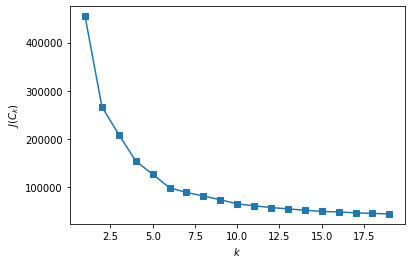

In [ ]:
def compactness_check(XXX):
    inertia = []
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(XXX)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(range(1, 20), inertia, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

compactness_check(Xl)

# Похоже, 5-7 структурных ролей присутствует

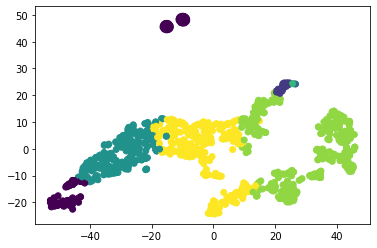

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xl)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xl)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

# Посмотрим, что там за кластера получились
(самые небольшие по размеру)

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 30:
        print(cityCodeCluster[item])

['Киров', 'Воронеж', 'Иркутск', 'Волгоград', 'Челябинск', 'Красноярск', 'Самара', 'Тюмень', 'Краснодар', 'Казань', 'Уфа', 'Тверь', 'Ростов-на-Дону', 'Сургут', 'Пермь', 'Нижний Новгород', 'Сочи', 'Саратов', 'Рязань', 'Омск', 'Новосибирск']
['Москва']
['Санкт-Петербург', 'Екатеринбург']


# Случай второй - добавим нелинейности
и получим более компактные представления вершин-городов

In [ ]:
Xn = np.array(X)

# подготовим данные в виде приятном для нейронок
Xn = xlogy(np.sign(Xn), Xn) / np.log(2)
Xn = Normalizer().fit_transform(Xn)

for i in range(2):
    Xn = graph_convolution(Xn, D)
Xn = graph_convolution(Xn, D, relu='off')

# индексация в матрице связности отличается на -1
Xn[cityCode['Москва']-1]

array([  0.44181188,   0.41628257,   0.33654059,   0.32299275,
         0.30717333,   0.18008575,   0.28217626,   0.33465871,
         0.17446905,   0.19562001,   0.05311199,   0.15489819,
         0.        ,  -0.        ,  -0.        ,   0.48995854,
         4.57710656,  -0.        ,  -0.        ,  -0.        ,
         1.42213218,  -0.        ,   2.49409036,  -0.09863698,
        -1.34592478,  -3.84514579,  -9.13638595, -12.02525608])

# Обратите внимание:
последние 5 колонок - результат трёх слоёв свёртки - наши эмбеддинги

In [ ]:
Xt = Xn[:, -5:]
Xt[cityCode['Москва']-1]

array([ -0.09863698,  -1.34592478,  -3.84514579,  -9.13638595,
       -12.02525608])

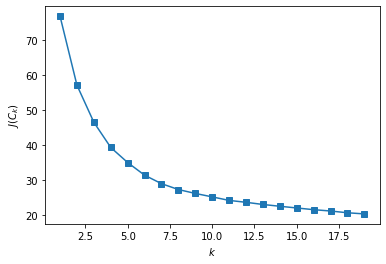

In [ ]:
compactness_check(Xn)

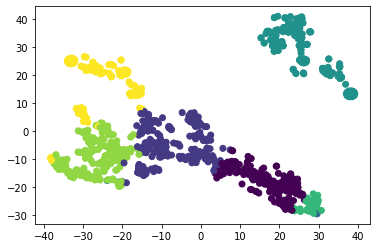

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xn)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xn)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}
cityCodeVector = {}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 
    cityCodeVector[item] = Xn[item-1]

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 40:
        print(cityCodeCluster[item])

['Москва']
['Иваново', 'Воронеж', 'Иркутск', 'Ярославль', 'Волгоград', 'Челябинск', 'Калуга', 'Владимир', 'Смоленск', 'Красноярск', 'Томск', 'Ставрополь', 'Самара', 'Тюмень', 'Краснодар', 'Казань', 'Санкт-Петербург', 'Вологда', 'Уфа', 'Петрозаводск', 'Тверь', 'Ростов-на-Дону', 'Сургут', 'Пермь', 'Нижний Новгород', 'Хабаровск', 'Екатеринбург', 'Великие Луки', 'Южно-Сахалинск', 'Магадан', 'Якутск', 'Саратов', 'Рязань', 'Омск', 'Новосибирск', 'Псков']


# Оценим, как эти вектора разделяют города и веси

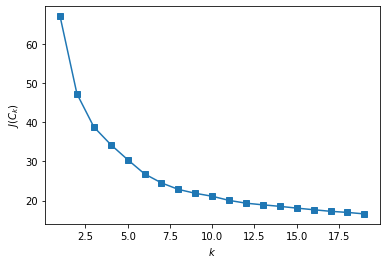

In [ ]:
compactness_check(Xt)

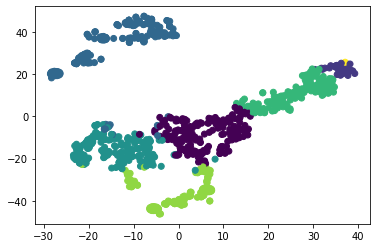

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xt)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xt)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}
cityCodeVector = {}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 
    cityCodeVector[item] = Xt[item-1]

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 40:
        print(cityCodeCluster[item])

['Чита', 'Иваново', 'Воронеж', 'Иркутск', 'Ярославль', 'Волгоград', 'Челябинск', 'Калуга', 'Владимир', 'Смоленск', 'Красноярск', 'Томск', 'Ставрополь', 'Самара', 'Тюмень', 'Абакан', 'Краснодар', 'Казань', 'Санкт-Петербург', 'Вологда', 'Уфа', 'Петрозаводск', 'Тверь', 'Ростов-на-Дону', 'Сургут', 'Пермь', 'Нижний Новгород', 'Хабаровск', 'Екатеринбург', 'Великие Луки', 'Южно-Сахалинск', 'Магадан', 'Якутск', 'Саратов', 'Рязань', 'Омск', 'Новосибирск', 'Псков']
['Москва']


# В результате мы получили два набора векторов свойств, приводящих к похожим результатам кластеризации
Теперь можно провести операцию пулинга и рассуждать о подобии социо-экономической структуры регионов, построенной из потоков пассажироперевозок

In [ ]:
SR = df[['sourceId', 'source_region']].groupby('sourceId').first().to_dict()['source_region']
TR = df[['targetId', 'target_region']].groupby('targetId').first().to_dict()['target_region']
SC = df[['sourceId', 'source_county']].groupby('sourceId').first().to_dict()['source_county']
TC = df[['targetId', 'target_county']].groupby('targetId').first().to_dict()['target_county']

cities = []

for item in range(1,len(codeCity)+1):
    cities.append((item, codeCity[item]))

cf = pd.DataFrame(cities, columns=['Code', 'City'])

cf['Region'] = cf['Code'].map(SR)
cf['Region'] = cf['Code'].map(TR)

cf['County'] = cf['Code'].map(SC)
cf['County'] = cf['Code'].map(TC)

cf['FeatureVectorGlobal'] = cf['Code'].map(cityCodeVector)

cf.head()

,Code,City,Region,County,FeatureVectorGlobal
0,1,Могоча,Zabaykalsky,Mogochinsky District,"[0.4810811031000692, 0.40444742893843716, 0.45..."
1,2,Котово,Volgograd,NaN,"[0.5980204496913621, 0.5399049009401314, 0.286..."
2,3,Кулебаки,Nizhny Novgorod,Kulebakskiy,"[0.7507445203164236, 0.5765429924625193, 0.322..."
3,4,Мензелинск,Tatarstan,Menzelinskiy,"[0.0, 0.7208445056652405, 0.0, 0.0, 0.0, 0.0, ..."
4,5,Горнозаводск,Perm,NaN,"[0.5331447981592271, 0.4694701881881087, 0.405..."


In [ ]:
rf = cf[['Region', 'FeatureVectorGlobal']].groupby('Region').agg(list)
regionVectors = {}

for item in rf.itertuples():
    Z = np.array(item[1])
    regionVectors[item[0]] = list(np.average(Z, axis=0))

cf['RegionFeatureVectorGlobal'] = cf['Region'].map(regionVectors)
cf.head()

,Code,City,Region,County,FeatureVectorGlobal,RegionFeatureVectorGlobal
0,1,Могоча,Zabaykalsky,Mogochinsky District,"[0.4810811031000692, 0.40444742893843716, 0.45...","[0.42909371528760265, 0.5234445511904696, 0.31..."
1,2,Котово,Volgograd,NaN,"[0.5980204496913621, 0.5399049009401314, 0.286...","[0.3159565746749043, 0.5729620020560896, 0.218..."
2,3,Кулебаки,Nizhny Novgorod,Kulebakskiy,"[0.7507445203164236, 0.5765429924625193, 0.322...","[0.5169110306027154, 0.4832634345022848, 0.355..."
3,4,Мензелинск,Tatarstan,Menzelinskiy,"[0.0, 0.7208445056652405, 0.0, 0.0, 0.0, 0.0, ...","[0.3059966967141067, 0.5258062882491027, 0.266..."
4,5,Горнозаводск,Perm,NaN,"[0.5331447981592271, 0.4694701881881087, 0.405...","[0.3381738032270636, 0.5707414683246634, 0.242..."


# Всё описанное можно повторить для отдельных видов транспорта
(подсказка - достаточно убрать комментарии в первой ячейке)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
% cd ..

/content


In [ ]:
% cd ./gdrive

/content/gdrive


In [ ]:
cd ./'My Drive'

/content/gdrive/My Drive


In [ ]:
cf.to_csv('Covid-19-tutu-Region-Vectors.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Avia.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Train.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Bus.csv', sep=';')

In [ ]:
% cd ../../

/content
